In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [3]:
class GradientBoosting:
    def __init__(self, n_estimators=10, max_depth=3, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.trees = []
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        resid = []
        resid.append(y)
        y_new = []
        gamma = 0.1
        for i in range(self.n_estimators):
            if i == 0:
                y_new.append(self._fit_predict_tree(x, resid[-1]))
                a = np.sum(y_new, axis=0)
                resid.append(y - a)
            else:
                predict = self._fit_predict_tree(x, resid[-1])
                self.gamma = np.min(minimize(self.func, x0 = [gamma, ], args = (predict, y, a)).x)
                y_new.append(self.gamma * self.learning_rate * predict)
                a = np.sum(y_new, axis=0)
                resid.append(y - a)
    
    def func(self, gamma, predict, y, a):
        result = mean_squared_error(y, a + gamma * predict)
        return result
    
    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(x, y)
        self.trees.append(tree)
        return tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        y_pred = []
        for i in range(len(self.trees)):
            if i == 0:
                y_pred.append(self.trees[i].predict(x))
            else:
                y_pred.append(self.gamma * self.learning_rate * self.trees[i].predict(x))
        y_pred = np.sum(y_pred, axis=0)
        return y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [4]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

C:\Users\Nikita Asket\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing da

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [6]:
import matplotlib.pyplot as plt

In [8]:
np.random.seed(19052019)
lr = 0.5
y = []
for i in range(1, 101):
    gd = GradientBoosting(n_estimators=i, max_depth=10, learning_rate=lr/i)
    gd.fit(X_train, y_train)
    y.append(mean_squared_error(y_test, gd.predict(X_test)))
print(np.min(y))



11.155906428170473


Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- __Да__

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [9]:
import catboost
from catboost import *
from catboost import datasets
from catboost import CatBoostClassifier

In [10]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [11]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [12]:
# Референс
from xgboost.sklearn import XGBClassifier
#import xgboost as xgb

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

xgb = XGBClassifier()
xgb.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1])

0.7062431441969361

In [13]:
X1_train_part, X1_valid, y1_train_part, y1_valid = train_test_split(train.values[:, :-1], y_train, test_size=0.3, random_state=42)

In [14]:
lst = [0, 1, 2, 4, 5, 6]
lst
pool1 = Pool(data=X1_train_part, label=y1_train_part, cat_features=lst)

In [15]:
from catboost import CatBoostClassifier, cv
params = {
    'use_best_model' : True,
    'early_stopping_rounds' : 100,
    'custom_metric' : 'AUC:hints=skip_train~false',
    'loss_function' : 'Logloss',
    'learning_rate' : 0.05,
    'iterations' : 2000
}
cv_data = cv(params = params, early_stopping_rounds = 100,
             pool = pool1, fold_count = 3,
             shuffle=True, partition_random_seed=0,
             plot=True, stratified=True,
            verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.4163944624
bestIteration = 1792

Training on fold [1/3]

bestTest = 0.4133078978
bestIteration = 1977

Training on fold [2/3]

bestTest = 0.417385598
bestIteration = 1783



In [16]:
cv_data.iterations.iloc[np.argmax(cv_data['test-AUC-mean'].values)]

1689

In [17]:
clf = CatBoostClassifier(learning_rate = 0.05, n_estimators = 1689, verbose=False)
clf.fit(pool1)
roc_auc_score(y1_valid, clf.predict_proba(X1_valid)[:, 1])

0.7654985860905452

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [18]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [19]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        
        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        self.clusters = (-1) * np.array(np.ones(X.shape[0]), dtype=np.int8)
        self.X = X
        

        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        cluster = 0
        for i in range(X.shape[0]):
            if self.clusters[i] == -1:
                neighbours = self.range_query(X[i])
                if len(neighbours) >= self.min_samples:
                    self.clusters[i] = cluster
                    self.grow_cluster(i, neighbours)
                    cluster += 1
        return self.clusters

    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        cluster = self.clusters[root]
        for i in neighbours:
            if self.clusters[i] == -1:
                self.clusters[i] = cluster
                new_neighbours = self.range_query(self.X[i])
                if len(new_neighbours) >= self.min_samples:
                    self.grow_cluster(i, new_neighbours)


    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        d = dbscan.dist(self.X, x)
        return np.where((d <= self.eps) & (d != 0))[0]
            
    
    @staticmethod
    def dist(X, x):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        return np.sqrt(((X-x) ** 2).sum(axis=1))

Проверим себя на простом примере:

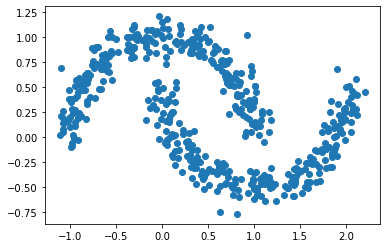

In [20]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

Референс:

[-1  0  1]


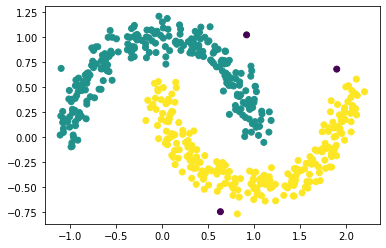

In [21]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)
print(np.unique(clusters))
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

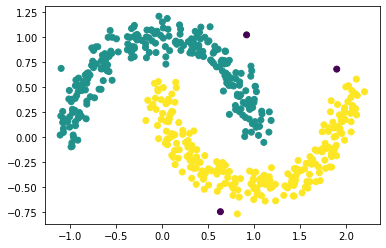

In [22]:
plt.scatter(X[:,0], X[:,1], c = dbscan(0.2, 10).fit_predict(X))
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



Или хотя бы что-нибудь такое: 

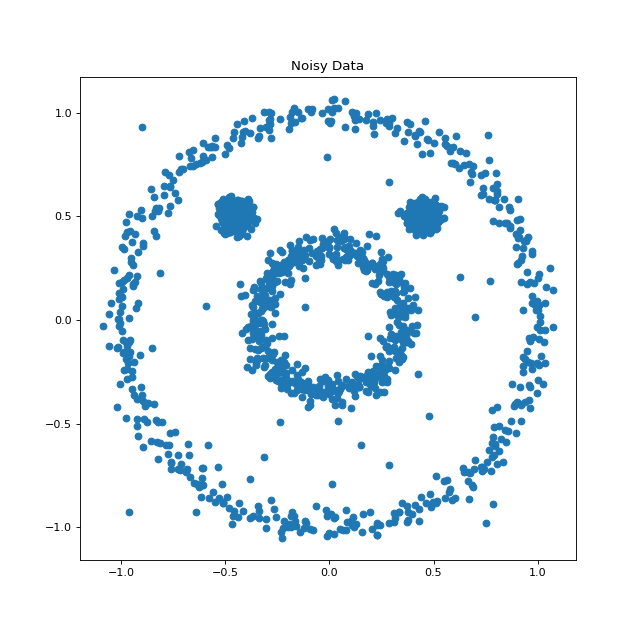

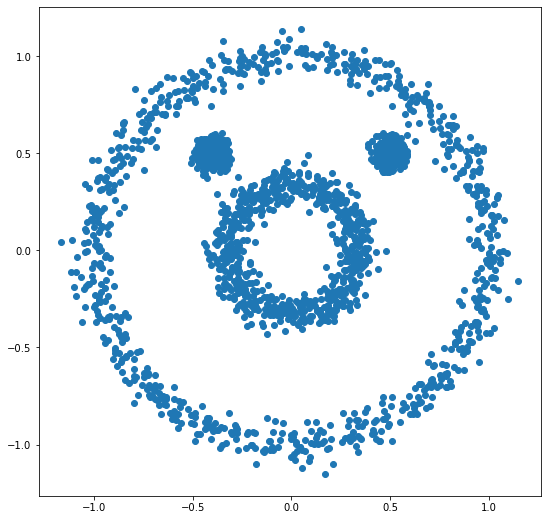

In [23]:
t = np.linspace(0, 2*np.pi, 800)
x = np.cos(t) + np.random.normal(0, 0.05, 800)
y = np.sin(t) + np.random.normal(0, 0.05, 800)
t = np.linspace(0, 2*np.pi, 700)
x = np.append(x, np.cos(t) / 3 + np.random.normal(0, 0.05, 700))
y = np.append(y, np.sin(t) / 3 + np.random.normal(0, 0.05, 700))
x = np.append(x, -0.4 + np.random.normal(0, 0.035, 700))
y = np.append(y, 0.5 + np.random.normal(0, 0.035, 700))
x = np.append(x, 0.5 + np.random.normal(0, 0.035, 700))
y = np.append(y, 0.5 + np.random.normal(0, 0.035, 700))
plt.figure(figsize=(9,9))
plt.scatter(x, y)
plt.show()

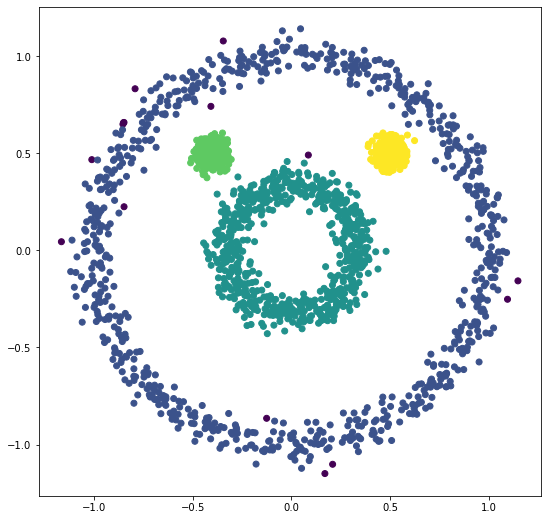

In [27]:
my_pic = np.array(list(zip(x, y)))
plt.figure(figsize=(9,9))
plt.scatter(x, y, c = dbscan(0.085, 10).fit_predict(my_pic))
plt.show()


> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [28]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: total: 0 ns
Wall time: 3.99 ms


In [29]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: total: 31.2 ms
Wall time: 30.9 ms


## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

In [30]:
# your code here  ლ(ಠ益ಠლ)
X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

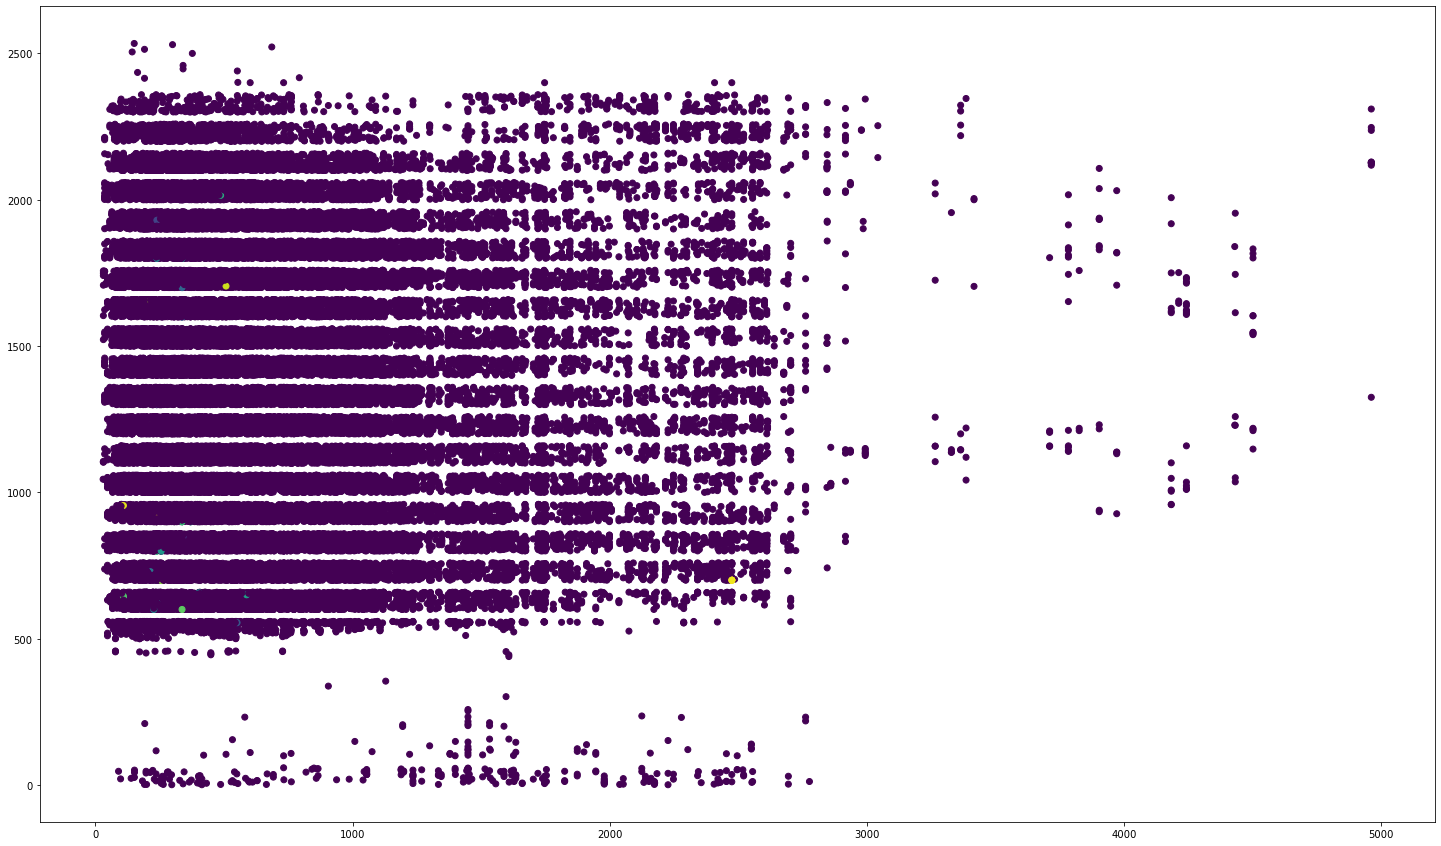

Кол-во кластеров:  40


In [31]:
plt.figure(figsize=(25,15))
clusters = DBSCAN().fit_predict(X_train_part)
plt.scatter(X_train_part[:,0], X_train_part[:,1], c = DBSCAN().fit_predict(X_train_part))
plt.show()
print('Кол-во кластеров: ', len(np.unique(clusters))-1)

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ Больше всего шумовых точек, когда расстояние eps слишком мало (точки находятся на большом расстоянии друг от друга) или min_samples слишком большой (слишком много соседей для условия, кластер не разрастается). 

eps = 5 min_samples = 5 len clusters = 2264


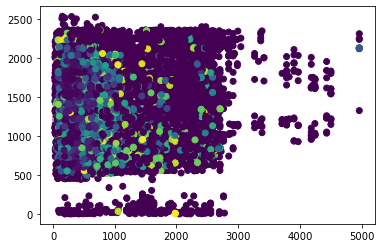

eps = 5 min_samples = 10 len clusters = 1076


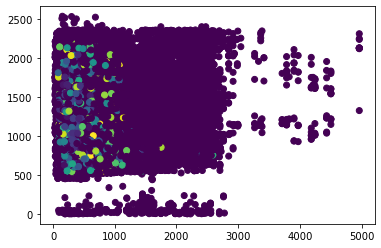

eps = 5 min_samples = 30 len clusters = 0


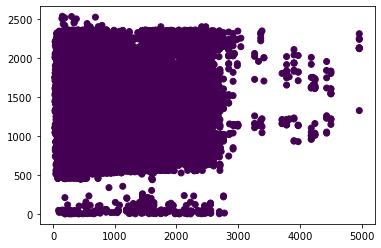

eps = 5 min_samples = 50 len clusters = 0


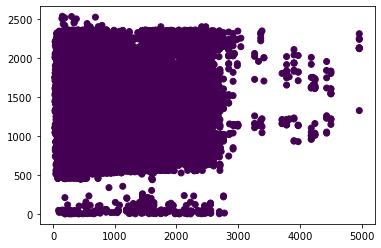

eps = 5 min_samples = 70 len clusters = 0


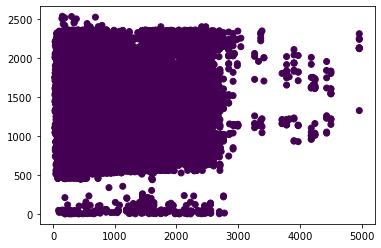

eps = 5 min_samples = 100 len clusters = 0


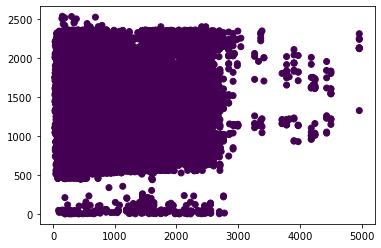

eps = 10 min_samples = 5 len clusters = 745


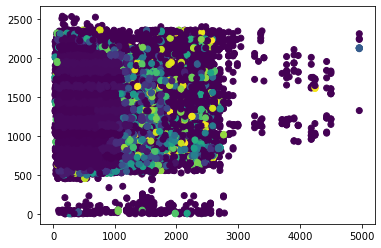

eps = 10 min_samples = 10 len clusters = 347


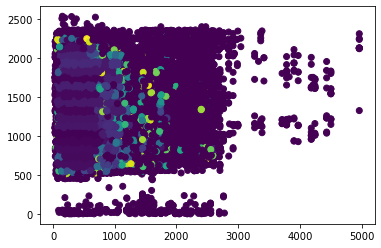

eps = 10 min_samples = 30 len clusters = 216


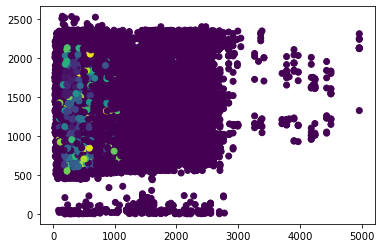

eps = 10 min_samples = 50 len clusters = 42


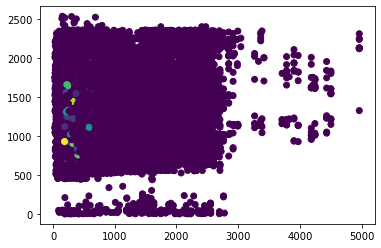

eps = 10 min_samples = 70 len clusters = 0


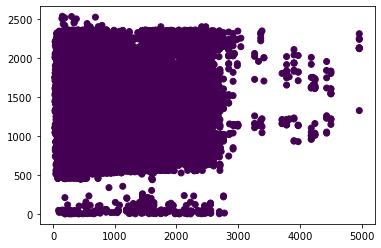

eps = 10 min_samples = 100 len clusters = 0


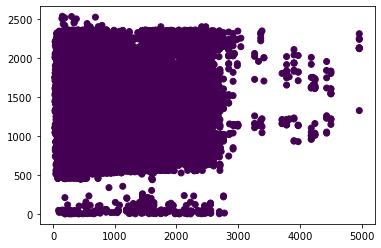

eps = 30 min_samples = 5 len clusters = 164


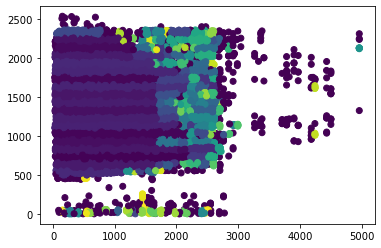

eps = 30 min_samples = 10 len clusters = 157


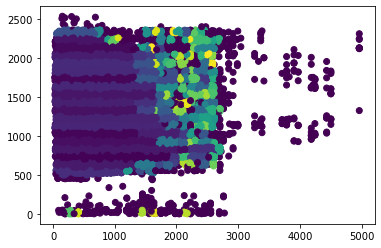

eps = 30 min_samples = 30 len clusters = 85


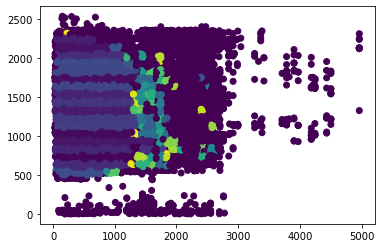

eps = 30 min_samples = 50 len clusters = 52


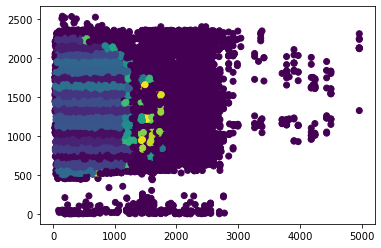

eps = 30 min_samples = 70 len clusters = 34


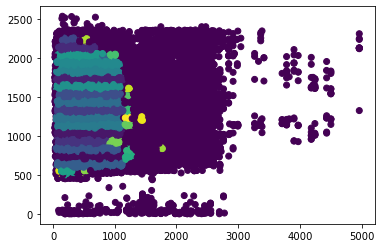

eps = 30 min_samples = 100 len clusters = 39


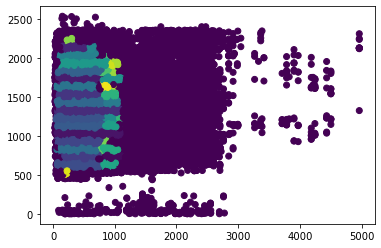

eps = 50 min_samples = 5 len clusters = 30


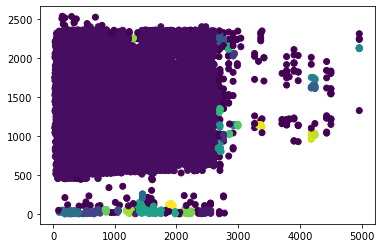

eps = 50 min_samples = 10 len clusters = 16


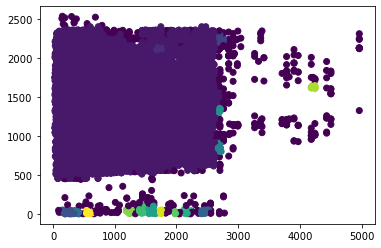

eps = 50 min_samples = 30 len clusters = 27


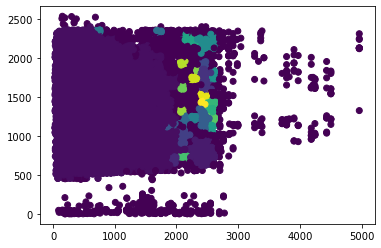

eps = 50 min_samples = 50 len clusters = 16


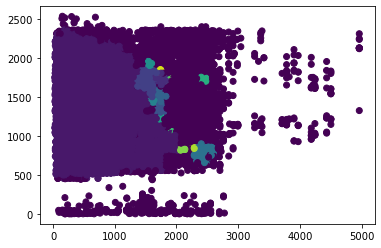

eps = 50 min_samples = 70 len clusters = 19


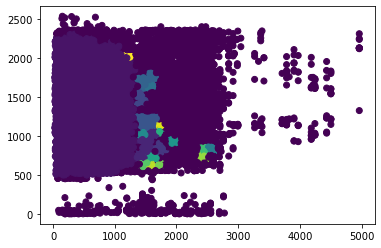

eps = 50 min_samples = 100 len clusters = 8


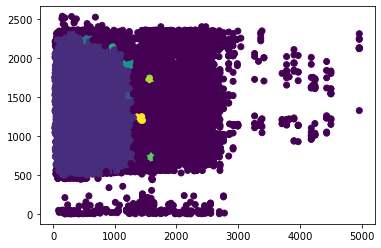

eps = 70 min_samples = 5 len clusters = 23


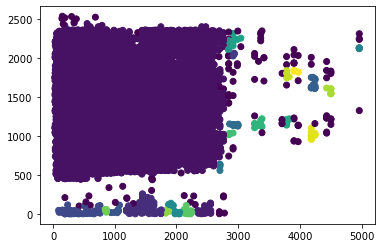

eps = 70 min_samples = 10 len clusters = 12


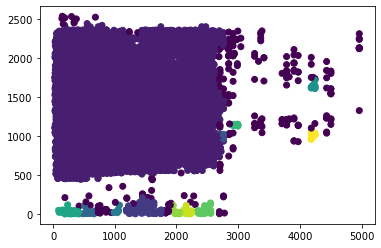

eps = 70 min_samples = 30 len clusters = 3


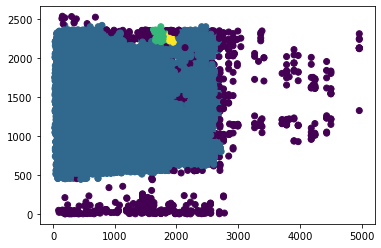

eps = 70 min_samples = 50 len clusters = 7


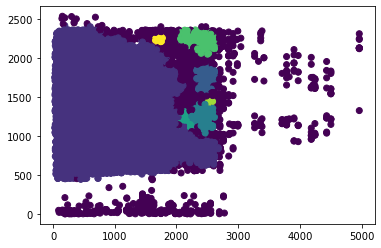

eps = 70 min_samples = 70 len clusters = 7


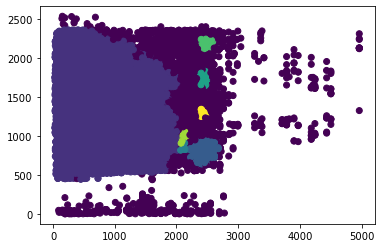

eps = 70 min_samples = 100 len clusters = 5


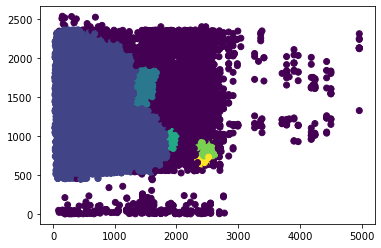

eps = 100 min_samples = 5 len clusters = 14


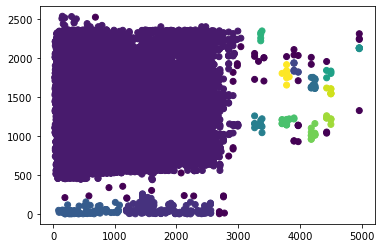

eps = 100 min_samples = 10 len clusters = 9


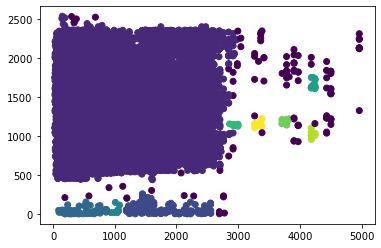

eps = 100 min_samples = 30 len clusters = 3


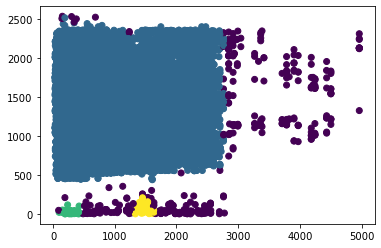

eps = 100 min_samples = 50 len clusters = 1


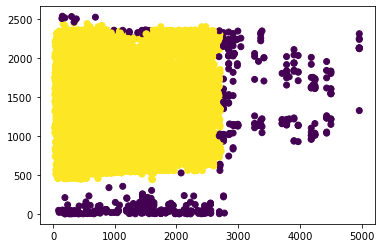

eps = 100 min_samples = 70 len clusters = 4


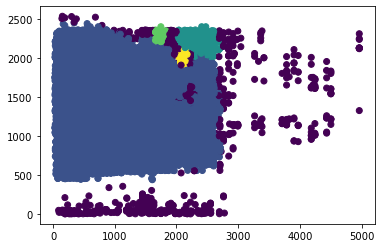

eps = 100 min_samples = 100 len clusters = 5


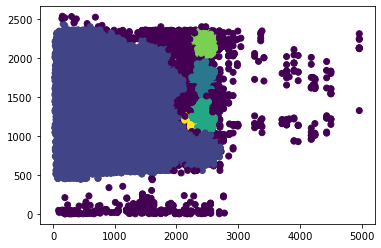

In [90]:
eps = [5, 10, 30, 50, 70, 100]
min_samples = [5, 10, 30, 50, 70, 100]
for i in range(len(eps)):
    for j in range(len(min_samples)):
        clusters = DBSCAN(eps=eps[i], min_samples=min_samples[j]).fit_predict(X_train_part)
        print('eps =', eps[i], 'min_samples =', min_samples[j], 'len clusters =', len(np.unique(clusters)) - 1)
        plt.scatter(X_train_part[:,0], X_train_part[:,1], c = clusters)
        plt.show()

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [29]:
clusters_train = DBSCAN().fit_predict(X_train_part)
clusters_valid = DBSCAN().fit_predict(X_valid)

In [30]:
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X1_train_part, X1_valid, y1_train_part, y1_valid = train_test_split(train.values[:, :-1],
                                                                    y_train, test_size=0.3,
                                                                    random_state=42)

In [31]:
clusters_train = clusters_train.reshape(70000, 1)
clusters_valid = clusters_valid.reshape(30000, 1)

In [33]:
X1_train_part = np.append(X1_train_part, clusters_train, axis = 1)
X1_valid = np.append(X1_valid, clusters_valid, axis = 1)

In [34]:
lst = [0, 1, 2, 4, 5, 6, 8]
lst
pool1 = Pool(data=X1_train_part, label=y1_train_part, cat_features=lst)

In [159]:
clf = CatBoostClassifier(learning_rate = 0.05, n_estimators = 1689, verbose=False)
clf.fit(pool1)
roc_auc_score(y1_valid, clf.predict_proba(X1_valid)[:, 1])

0.765829260057539

__Ответ:__ Ошибка почти не изменилась, скорее всего, т.к. у этого признака маленький вес. 